【Task3 XGB算法梳理】
【参考框架】欢迎有自己的框架
XGB

1，算法原理
2，损失函数
3，分裂结点算法
4，正则化
5，对缺失值处理
6，优缺点
7，应用场景
8，sklearn参数

In [37]:
'''
9、xgb sklearn应用
'''
from sklearn import datasets
import numpy as np
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [42]:


myDatas = datasets.load_iris()
#print("训练数据",myDatas)
#划分训练集、测试集
X_train,X_test,y_train,y_test = train_test_split(
    myDatas.data,myDatas.target,#load_iris的原始数据集
    test_size = 0.3,
    random_state = 7
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(105, 4)
(45, 4)
(105,)
(45,)


In [92]:

#==分类任务==
#实例化xgb分类器对象
clfXgb = XGBClassifier(n_estimators=10,max_depth=3,learning_rate=0.1)
#learning_rate = 0.1 根据经验是最合适的学率，精确度0.93，改成0.5，精确度降为0.91了。
#训练分类
clfXgb.fit(X_train,y_train)
#预测
clfXgbPred = clfXgb.predict(X_test)

#评估得分
acc = accuracy_score(y_test,clfXgbPred)

print("预测精确度：",acc)

#==以上就完成了sklearn的XGBoost分类预测了==

#==回归任务==
#同上，换成XGBRegressor
#rXgb = XGBRegressor(n_estimators=10,max_depth=3)



预测精确度： 0.9333333333333333


G:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
#==下面来看下每一步的test预测值，
#看是否XGBoost每加一棵树都会让集成学习效果优化提升(这是XGBoost的核心思想)==

eval_set = [(X_test,y_test)]#构造一个测试集

clfXgb.fit(X_train,y_train,early_stopping_rounds=3,
           eval_metric='mlogloss',eval_set = eval_set,verbose = True)
#参数：模型饱和后再加3次停止该模型
#指定mlogloss为损失函数，用来做模型优化标准，使logloss最小。
#测试值
clfXgbPred_2 = clfXgb.predict(X_test)
#把预测值装进预测值列表
predictions = [round(v) for v in clfXgbPred_2]
#遍历预测结果评估
acc_2 = accuracy_score(y_test,predictions)#每个测试结果和它对应的所有预测值比较分别评估

print("\n预测精确度:",acc_2)
#由结果可见XGB的确是在每步加入新村时使得集成学习向优化提升（损失越来越小，预测越来越接近真实值）
#另外上面设了early_stopping_rounds 为3 说明从底下往上数3个0.56时模型就已经是饱和状态了。

[0]	validation_0-mlogloss:0.871668
Will train until validation_0-mlogloss hasn't improved in 3 rounds.
[1]	validation_0-mlogloss:0.714822
[2]	validation_0-mlogloss:0.600959
[3]	validation_0-mlogloss:0.51605
[4]	validation_0-mlogloss:0.451743
[5]	validation_0-mlogloss:0.402619
[6]	validation_0-mlogloss:0.364957
[7]	validation_0-mlogloss:0.336098
[8]	validation_0-mlogloss:0.310766
[9]	validation_0-mlogloss:0.290692

预测精确度: 0.9333333333333333


G:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


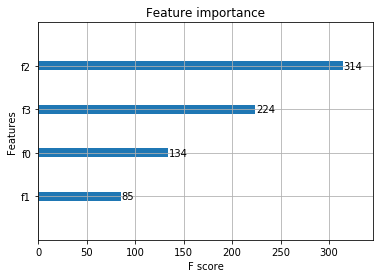

In [69]:
#==下面看一个xgboost的功能
#plot_importantce，
#可以查看特征重要性==
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()#实例化分类器对象
model.fit(myDatas.data,myDatas.target)#对象fit传原始数据集即可
rs = plot_importance(model)#算特征重要性
pyplot.show(rs)#画图
#图上列出了4个特征重要性



In [71]:
#==网格调参，
#模型建好以后要选一些合适的参数，让模型最优（损失最小）才是目的，
#然后把这些参数应用到模型，重新建模保存，服务于更多任务的测试工作==
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [94]:
myMode = XGBClassifier()#正常这里是不会人为揸定参数，要求最合适参数，上面实例只是根据经验传了固定参数展示分类实现，
#以学习率为例，找一个最合适的学习率
#设几个不同学习率的列表，后面来遍历它，看哪个学习率下分类精确度最高，就用哪个学习率代回模型重新建模
learning_rate=[0.0001,0.001,0.1,0.2,0.3]
#这次使用交叉验证（交替充份使用有限数据）划分数据集
#实例化交叉验证类
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=7)
#n_splits分成几组测试验证对
#实例化网格调参类（传入交叉验实例对象及XGB分类对象）
grid_search = GridSearchCV(myMode,#传入XGB分类对象
                           dict(learning_rate=learning_rate),#这里要字典格式打包传参
                           scoring = 'neg_log_loss',#评估损失函数选择
                           n_jobs = 1,#当前所有空闲CPU都去跑这个模型
                           cv = kfold#指定交叉验证实例对象
                          )
#用最终结合好的对象fit原始数据即可自动完成交叉验证并调参
gridRs = grid_search.fit(myDatas.data,myDatas.target)

#打印最优学习率和其得分
print("最优学习率: %s ，得分：%f " % (gridRs.best_params_,gridRs.best_score_))
means = gridRs.cv_results_['mean_test_score']
params = gridRs.cv_results_['params']
#打印平均分
print("每次迭代的平均值：",means)
print("对应的本次迭代学习率参数：",params)

'''
#以上调参完即可确定最优的learning_rate在模型中使用了，代回去再次建模，
#才可得到开篇中的最精确的预测值。
#试下把开篇learning_rate = 0.1 改成0.5，精确度从0.93降为0.91了。
#此模型才可用于其它同类任务的预测工作，总的流程是这样的。
#此处只调了一个参数举例，其它参数必要时也要调
'''

最优学习率: {'learning_rate': 0.1} ，得分：-0.169467 
每次迭代的平均值： [-1.08640095 -0.98505858 -0.169467   -0.18732891 -0.18775922]
对应的本次迭代学习率参数： [{'learning_rate': 0.0001}, {'learning_rate': 0.001}, {'learning_rate': 0.1}, {'learning_rate': 0.2}, {'learning_rate': 0.3}]


In [ ]:
'''
XGB

1，算法原理
XGB(extreme Gradient Boosting) 最强梯度提升树
它是一种集成学习算法，把弱分类器（决策树）组合，逐步提升效果，变强学习器。
它的提升原理是：把之前树的预测结果保留下来，加上当前树的结果，使效果最好（使加起来的预测结果最接近真实值），
但这棵树怎么加，要不要加，不是乱加的，前提是要使整体效果提升，
所以这个算法也当成是一个提升boosting算法。
怎么做到新加的树是使整体效果提升的？
就要通过计算损失函数，使它是下降的（损失降低的）

2，损失函数
损失函数 L = (预测值-真实值)^2 
目标函数（要求的函数） = L损失函数 + 正则惩罚项
正则惩罚项 = 惩罚系数（力度）*T叶子结点数+L2正则项(0.5*参数*样本权重平方和)
L损失（预测值-真实值）这个差值也叫残差（梯度提升决策树也叫残差决策树）
求它的最小值（每棵树的要累加起来），就是我们的目标，
XGBoost的原理就是让这个差值最小，也即预测值最接近真实值，

公式最终化简为一个叶节点权重w = 一阶导g之和/二阶导h之和+参数，
要使得把它代回原目标函数损失最小。

它公式推导化简求解过程中用了泰勒展开（用近似的简单表达来代替复杂的函数代表求解），
求一阶导和给一阶导求二阶导（给导数求导即求一个倾斜角度的角度，在前面的基础上的变化）的算梯度方式，
更精确快速定位下降的方向。

3，分裂结点算法
分裂结点即在哪里切分做为划分子左右树的依据，
决策树用的是算熵值、基尼系数，来找一个最大特征项来切分，
XGBoost是指定分割点，用左子树+右子树分数-没切割时的树得分 这样得到一个切分后的预测结果增益变化值，
指定很多个分割点迭代，增益变化最大的（如果没变化，等于没切一样，所以找增益最大的点来切割）这个分割点阈值作为切分依据，
在此处分裂结点。


4，正则化
决策树的叶子结点过多会过拟和，所以引入了正则化，
在损失函数后面+正则化项
正则化项 = 惩罚系数（力度参数）*T叶子结点数+L2正则项(0.5*参数*叶子权重平方和)
两部分的两个参数都是人为指定，分别控制叶子结点数和单个结点的权重，让两者平衡，共同作用，使损失函数最小。

5，对缺失值处理
对缺失值XGBoost可以自动学习分裂方向，
自动学习的实现是通过以下方式：
在找分裂点时，不遍历迭代缺失样本，减少计算，
分配样本时，缺失的样本同时分到左右子树，计算哪边的增益大就自动分到哪边去。
但在测试时如果遇到缺失值，会分到右子树。

6，优缺点
优点：
a,支持线性分类器（相当于引入L1 L2正则惩罚项的LR和线性回归，目标函数公式=误差平方和+正则项，似LR）;
b,代价函数（）用了二阶Talor展开，引入一阶导和二阶导,提高模型拟和的速度；
（损失函数：一个样本的误差
代价函数：整个训练集上所有样本误差的平均
目标函数：代价函数 + 正则化项）
c,可以给缺失值自动划分方向；
d,同RF,支持样本(行)随机抽取，也支持特征(列)随机抽取，降低运算，防过拟合；
e,代价函数引入正则化项，控制模型（树）复杂度，
正则化项包含全部叶子节点个数，每个叶子节点得分的L2模的平方和（代表叶子节点权重的影响）
从贝叶斯（先验累积思想）方差角度考虑，正则降低了模型的方差，防过拟和；
f,每次迭代后为叶子分配结合学习速率，减低每棵树权重，减少每棵树影响，灵活调整后面的学习空间；
g,支持并行，不是树并行，是把特征值先预排序，存起来，可以重复并行使用计算分裂点；
h,分裂依据分开后与未分前的差值增益，不用每个节点排序算增益，减少计算量，可以并行计算，
可以引入阈值限制树分裂，控制树的规模；
总结优点：快速高效可容错

缺点：
a,容易过拟合；
b,调参困难；

7，应用场景

用于分类；
用于回归；

8，sklearn参数

XGBClassifier参数:
    learning_rate = 0.1, #学习率
    n_estimators=100, #分多少棵树
    max_depth=5, #树最大深度
    min_child_weight=1,#最小权重系数
    gamma=0,#惩罚系数（力度）
    lambda,#正则化
    alpha,#正则化
    subsample=0.8,#随机选80%个样本，不想随机就指定1
    colsample_bytree = 0.8 #随机选特征
    objective = 'binary:logistic'#损失函数loss function,求这个函数的一阶二阶导
    scale_pos_weight = 1 #要不要指定一个均衡的树
    seed=7 #随机种子，每次复现都是一样的

'''